In [1]:
!pip install -U autoreject

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.9 MB/s eta 0:00:00


In [2]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import mne

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# set the participant number
PNUM = "14"

In [6]:
RAW_EOG_CHANNELS = [u'EXG1', u'EXG2', u'EXG3', u'EXG4']
MASTOID_CHANNELS = [u'EXG5', u'EXG6']

In [7]:
data_raw_file = os.path.join("/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne/", 'P' + PNUM + '-raw.fif')
# data_raw_file = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne"
raw = mne.io.read_raw_fif(data_raw_file)

Opening raw data file /content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/mne/P14-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 66)  idle
    Range : 0 ... 2465433 =      0.000 ...  4815.299 secs
Ready.


F = frontal
Fp = frontopolar
T = temporal
C = central
P = parietal
O = occipital
A = auricular (ear electrode)
The localization of the brain waves within the brain regions or lobes is further narrowed by adding electrodes, which are given numbers such as T3, T4, P3, P4. Even numbers identify electrode positions on the right side of the head, and odd numbers refer to the left side. The label "z" points to electrode sites in the midline of the head. For example, Cz refers to the midline central region of the head.

## Dipole - eye blinks 
### link -> https://neuraldatascience.io/7-eeg/erp_artifacts.html
The neurons in the retina are organized in a highly oriented fashion, such that they form an electrical dipole — a source with positive and negative poles. This is exactly the kind of electrical source that EEG is good at detecting. As long as the eye’s position doesn’t change, the diploe created by the retina doesn’t affect EEG recordings, because it is constant (not changing). However, as the eye moves to look at different locations in space, the dipole moves, and this is detected by the electrodes on the scalp. When they eyes move to the left or right, the effect on EEG electrodes is that the electrical potential will increase at frontal electrodes on one side of the head, and decrease on the other side. Which side becomes more positive or negative depends on the direction of the movement.

<Raw | P14-raw.fif, 71 x 2465434 (4815.3 s), ~80 kB, data not loaded>
<Info | 11 non-empty values
 bads: 2 items (T7, F7)
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 66 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 104.0 Hz
 meas_date: 2015-03-06 11:30:43 UTC
 meas_id: 4 items (dict)
 nchan: 71
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Using matplotlib as 2D backend.


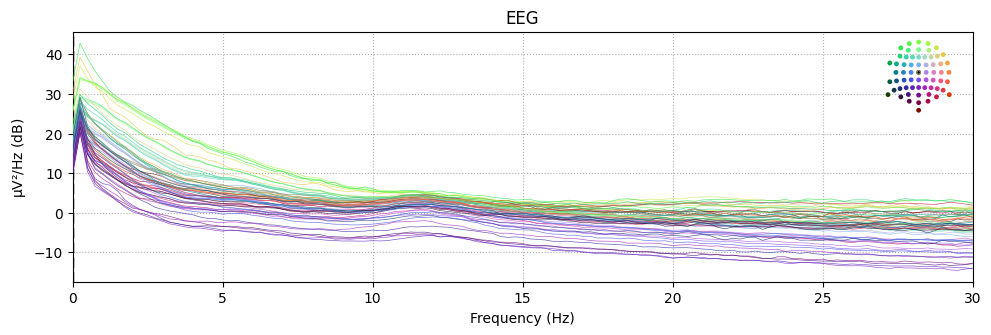

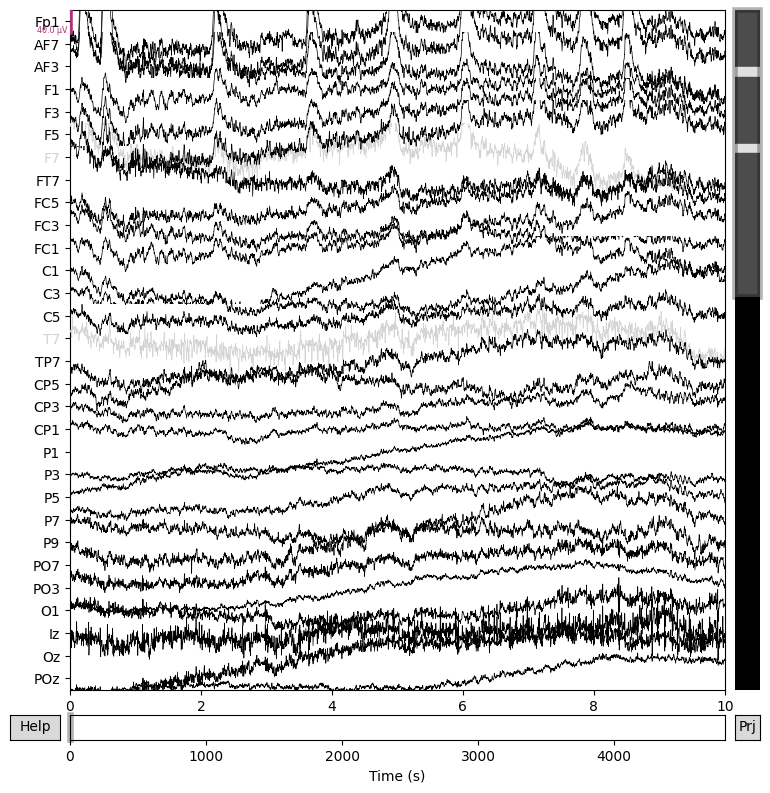

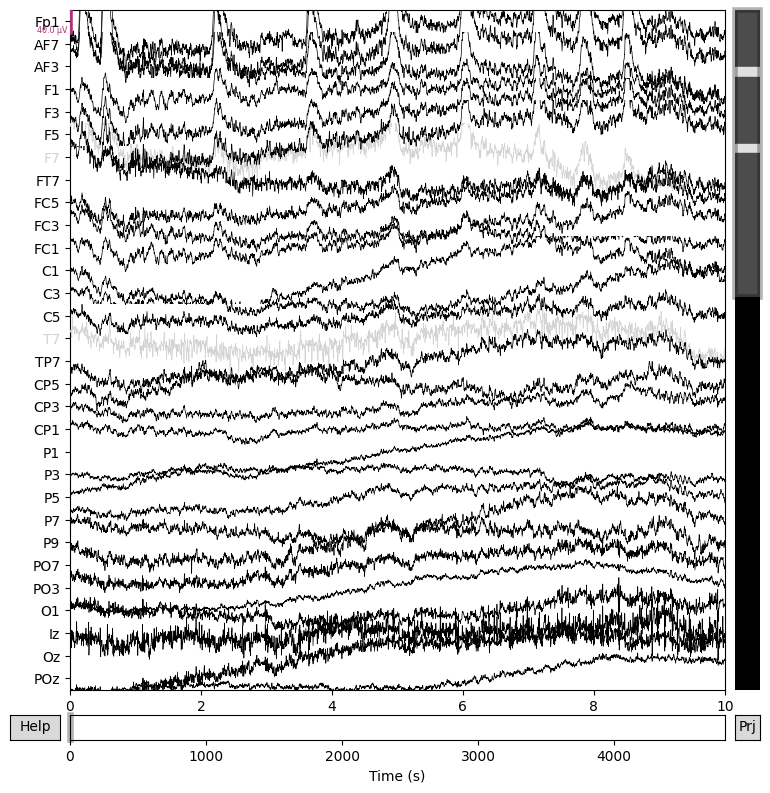

In [8]:
print(raw)
print(raw.info)

# plot eeg data
raw.plot_psd(fmax=30)
# raw.plot(duration=5, n_channels=30)
raw.plot( n_channels=30)

In [9]:
# mastoid channel stuff - according to openmirr repo
if MASTOID_CHANNELS[0] in raw.ch_names:
    mne.io.set_eeg_reference(raw.load_data(), MASTOID_CHANNELS, copy=False) # inplace
    raw.drop_channels(MASTOID_CHANNELS)


Reading 0 ... 2465433  =      0.000 ...  4815.299 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


In [10]:
# Drop bad channels - in place on raw
for bad_channel in raw.info['bads']:
    raw.drop_channels(bad_channel)
    print("dropped: " + bad_channel)

dropped: T7
dropped: F7


In [11]:
RAW_COPY = raw.copy()

eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])

# bandpass filter - keeping a frequency range between 0.5 (high pass filter) and 30 Hz (low pass filter)
filtered_data = raw.load_data().filter(0.5, 30, picks=eeg_picks)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    5.7s finished


### RUN BELOW CODE IF ICA NOT GENERATED

In [12]:
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(filtered_data, duration=tstep)
epochs_ica = mne.Epochs(filtered_data, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Not setting metadata
4815 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4815 events and 513 original time points ...
0 bad epochs dropped


In [13]:
from autoreject import get_rejection_threshold

reject = get_rejection_threshold(epochs_ica);
reject

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


{'eeg': 0.00013284928614601301, 'eog': 0.0009957486170084073}

In [14]:
# ICA parameters
random_state = 42   # ensures ICA is reproducable each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

Fitting ICA to data using 62 channels (please be patient, this may take a while)


<ipython-input-14-52653a6ac725>:9: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica,


Selecting by explained variance: 25 components
Fitting ICA took 163.5s.


Method,fastica
Fit,55 iterations on epochs (2470095 samples)
ICA components,25
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,—


In [15]:
# set up and fit the ICA - infomax method
# ica = mne.preprocessing.ICA(method='infomax')
# ica.fit(filtered_data)

In [16]:
print(dir(ica))

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply_epochs', '_apply_evoked', '_apply_raw', '_check_exclude', '_check_n_pca_components', '_check_target', '_compute_pre_whitener', '_do_proj', '_export_info', '_find_bads_ch', '_fit', '_fit_epochs', '_fit_raw', '_get_ctps_threshold', '_get_explained_variance_ratio_one_ch_type', '_get_infos_for_repr', '_get_picks', '_ica_names', '_max_pca_components', '_pick_sources', '_pre_whiten', '_repr_html_', '_reset', '_sources_as_epochs', '_sources_as_evoked', '_sources_as_raw', '_transform', '_transform_epochs', '_transform_evoked', '_transform_raw', '_update_ica_names', '_update_mixing_matrix', 'allow_ref_meg', 'apply', 'ch_names', 'com

In [17]:
# auto-detect artifacts by simple statistics
# ica.exclude = []
# ica.detect_artifacts(filtered_data)
# print(ica.exclude)

Using EOG channel: EXG1
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


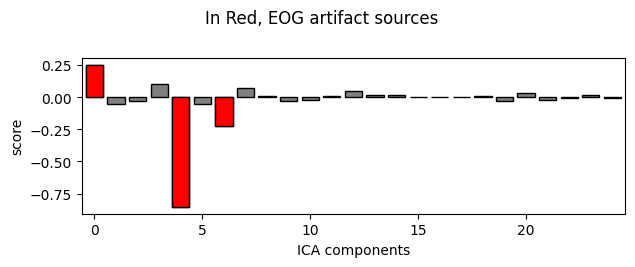

[4, 0, 6]

Using EOG channel: EXG2
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


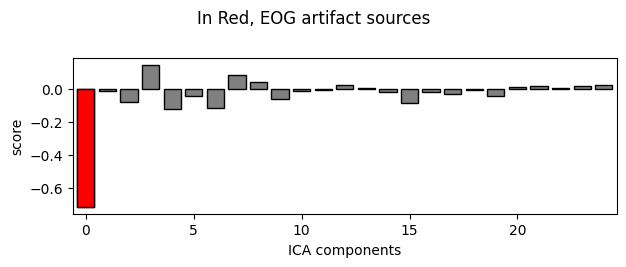

[0]

Using EOG channel: EXG3
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


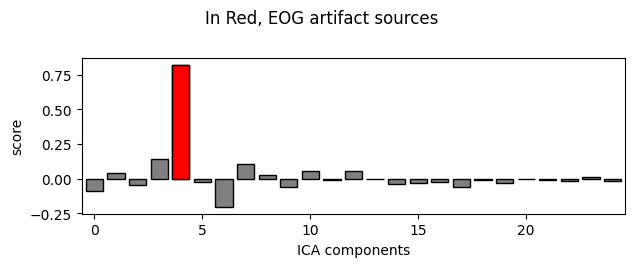

[4]

Using EOG channel: EXG4
... filtering ICA sources
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 30.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


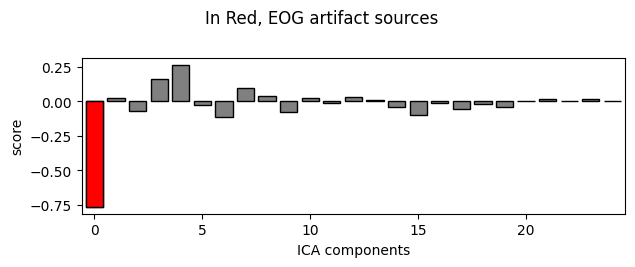

[0]



In [18]:
bad_comps = set()

for eog_channel in RAW_EOG_CHANNELS:
    bad, scores = ica.find_bads_eog(filtered_data, ch_name=eog_channel, l_freq=0.5, h_freq=30)
    ica.plot_scores(scores, exclude=bad, title='In Red, EOG artifact sources')
    bad_comps.update(bad)
    print(bad)
    print("=========================\n")

In [19]:
bad_comps

{0, 4, 6}

Using EOG channels: EXG1, EXG2, EXG3, EXG4
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 5120 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


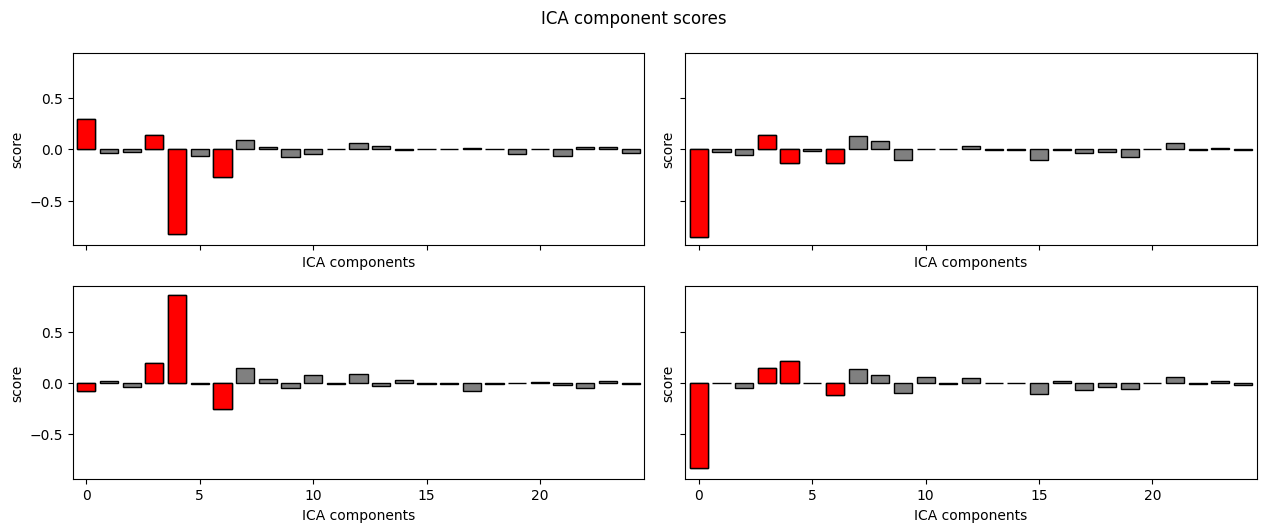

[4, 0, 6, 3]


In [20]:
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(filtered_data, 
                                            ch_name=RAW_EOG_CHANNELS, 
                                            threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores);
print(eog_indices)

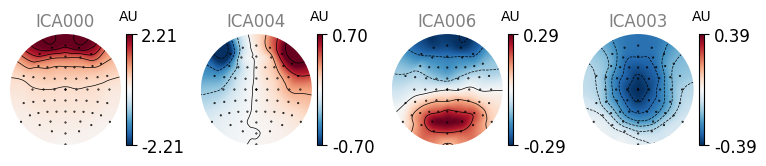

In [25]:
# view ica components to remove based on EOG correl
# bad eogs - 0,4,6
# previously it was 0,4,6,3
ica.plot_components(picks=[0,4,6,3], ch_type='eeg', title='', colorbar=True, show=True);
#not sure if 6 is an EOG artifact

In [26]:
# combine excluded components
ica.exclude.extend(list(bad_comps))
print(list(set(ica.exclude)))

[0, 3, 4, 6]


In [23]:
# save ICA result for later
# /content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/glissando_goblins_classificatioin/ica_components+epoch+artifact_removal
ica.save('/content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/glissando_goblins_classificatioin/ica_components+epoch+artifact_removal/P'+PNUM+'/P' + PNUM + '-ica.fif', overwrite=True)

Writing ICA solution to /content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/glissando_goblins_classificatioin/ica_components+epoch+artifact_removal/P14/P14-ica.fif...


Method,fastica
Fit,55 iterations on epochs (2470095 samples)
ICA components,25
Available PCA components,62
Channel types,eeg
ICA components marked for exclusion,ICA004ICA000ICA006ICA003ICA000ICA004ICA006


In [24]:
ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': 30});

Output hidden; open in https://colab.research.google.com to view.

### Spectrum graph in plot_properties?
In EEG (electroencephalography) analysis, the spectrum refers to the frequency content of the EEG signal. EEG signals are composed of different frequency components that reflect the underlying neural activity in the brain.The spectrum of an EEG signal is typically obtained by performing a Fourier transform on the signal, which decomposes the signal into its constituent frequencies. The resulting spectrum is often visualized as a power spectral density (PSD) plot, which shows the power of the EEG signal at each frequency.The frequency content of an EEG signal is typically divided into several frequency bands, including delta (0.5-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), beta (12-30 Hz), and gamma (30-100 Hz) bands. Each frequency band is associated with different cognitive and neural processes. For example, the delta band is often associated with deep sleep and unconscious processes, while the alpha band is associated with relaxed wakefulness and attentional processes.Spectrum analysis of EEG signals is widely used in neuroscience research to study brain function and to identify abnormalities in brain activity that may be associated with neurological or psychiatric disorders.

### Segments graph in plot_properties
In EEG (electroencephalography) analysis, segmenting refers to dividing the continuous EEG data into smaller segments or epochs, typically lasting a few hundred milliseconds to a few seconds. This is usually done to isolate and analyze specific events or processes in the brain that are related to a particular task or stimulus. Segmentation can be performed based on specific triggers or markers in the data, such as the onset of a stimulus or a particular response from the participant.ERP (event-related potentials) and ERF (event-related fields) are two types of EEG signals that are often analyzed after segmenting the data. ERP/ERF analysis involves averaging the EEG signals across multiple trials or segments that are time-locked to a specific event, such as the onset of a stimulus or the participant's response to a task. The resulting waveform reflects the brain's response to the event of interest, and can provide insights into the timing, location, and nature of the underlying neural processes.ERP is typically used to refer to EEG signals measured on the scalp, while ERF refers to magnetic fields measured using magnetoencephalography (MEG). However, the two terms are often used interchangeably in the literature. Both ERP and ERF analysis are widely used in cognitive neuroscience research to study a variety of cognitive processes, such as attention, perception, memory, and language processing.


### plot_properties explanation of each figure
topo map

raster plot of how the IC weights on each trial. Artifacts like blinks should appear as “streaks” lasting about 200-300 ms, on relatively few trials. Components reflecting brain activity are typically present across many epochs (although remember that these data are segmented into 1 s epochs across the entire raw data set, so we would not expect to see time-locked activity here)

Variance of the component, across channels and time. The x axis is epochs (effectively, time across the experiment), and the y axis is the variance of the IC across channels. Noise typically manifests as high variance on a low number of trials, and low variance on most trials, or lots of variability in the values on the y axis over epochs. True brain activity usually appears as consistently similar — and low — variance across epochs.

The PSD (phase spectral density) of the IC. EOG (eye) artifacts will typically have a peak at the low frequency end of the spectrum (the left side of the x axis), and muscle artifact will tend to show increasing power at the high end of the frequency spectrum (the right side of the x axis).